<a href="https://colab.research.google.com/github/JakeOh/202011_itw_bd21/blob/main/lab_ml/ml21_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   IMDB 데이터 셋을 다운로드 - 가장 자주 사용되는 500개의 어휘 사전을 사용.
*   각 샘플(리뷰)의 최대 단어 숫자가 100이 되도록 자르거나 패딩.
*   LSTM 순환 층을 2개를 연결하는 모델을 생성
    *   Input --> Embedding --> LSTM  --> LSTM --> Output
        *   LSTM 층의 unit 개수 = 16
        *   LSTM 층의 dropout 비율 = 0.3
*   모델 컴파일
*   모델 훈련
*   학습 곡선 - 손실 곡선, 정확도 곡선
*   모델 평가

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

# IMDB dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=10_000)
# 어휘 사전에서 자주 등장하는 단어 10,000개를 사용한 데이터 셋

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
x_train_full.shape

(25000,)

In [4]:
for i in range(5):
    print(len(x_train_full[i]))

218
189
141
550
147


In [5]:
np.unique(y_train_full, return_counts=True)

(array([0, 1]), array([12500, 12500]))

샘플(영화 리뷰)들마다 사용된 단어 수가 다르기 때문에 일정한 크기로 맞춰줄 필요가 있음. --> 모든 샘플의 길이(단어 수)를 500개로 자르거나 패딩.

In [6]:
x_train_seq = keras.preprocessing.sequence.pad_sequences(sequences=x_train_full, maxlen=500)
x_test_seq = keras.preprocessing.sequence.pad_sequences(sequences=x_test, maxlen=500)

In [7]:
x_train_seq.shape

(25000, 500)

In [9]:
x_test_seq.shape

(25000, 500)

전처리가 끝난 전체 훈련 셋을 훈련 셋/검증 셋으로 분리

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_seq, y_train_full,
                                                  test_size=0.2,
                                                  stratify=y_train_full,
                                                  random_state=42)

In [11]:
x_train.shape, x_val.shape

((20000, 500), (5000, 500))

In [12]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([10000, 10000]))

# LSTM model

In [16]:
model = keras.Sequential(layers=[
    # Embedding layer
    keras.layers.Embedding(input_dim=10_000, output_dim=16, input_length=500),
        #> input_dim=최대 특성 개수(어휘 사전에서 선택한 단어 수)
        #> input_length=샘플 하나가 가지고 있는 특성 수(단어 수)
        #> output_dim=순환층의 unit의 개수
    # LSTM layer
    keras.layers.LSTM(units=16, dropout=0.3, return_sequences=True),
        #> return_sequences=순환층의 출력이 다른 순환층의 입력으로 사용될 때 True로 설정
    keras.layers.LSTM(units=16, dropout=0.3),
    # Output layer
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 16)           2112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 164,241
Trainable params: 164,241
Non-trainable params: 0
_________________________________________________________________


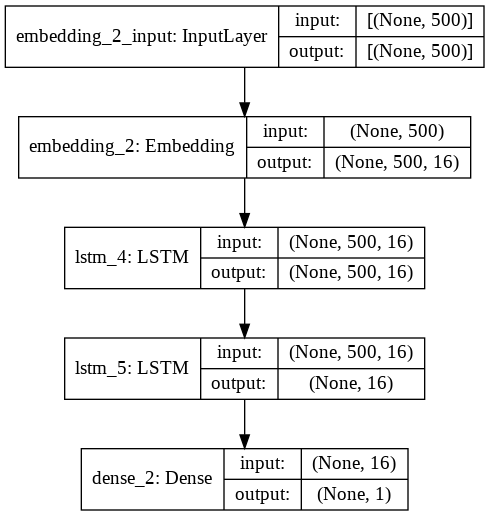

In [18]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일

In [19]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')

## 모델 훈련

In [20]:
# 콜백(조기 종료, 상태 저장)
early_stop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm2_model.h5', save_best_only=True)

# 훈련
history = model.fit(x_train, y_train, batch_size=64, epochs=100,
                    callbacks=[early_stop_cb, checkpoint_cb],
                    validation_data=(x_val, y_val))

Epoch 1/100
313/313 [==============================] - 45s 36ms/step - loss: 0.5861 - accuracy: 0.6650 - val_loss: 0.3547 - val_accuracy: 0.8578
Epoch 2/100
313/313 [==============================] - 11s 34ms/step - loss: 0.3081 - accuracy: 0.8781 - val_loss: 0.3445 - val_accuracy: 0.8554
Epoch 3/100
313/313 [==============================] - 11s 34ms/step - loss: 0.2365 - accuracy: 0.9103 - val_loss: 0.3710 - val_accuracy: 0.8568
Epoch 4/100
313/313 [==============================] - 10s 33ms/step - loss: 0.2038 - accuracy: 0.9202 - val_loss: 0.2998 - val_accuracy: 0.8886
Epoch 5/100
313/313 [==============================] - 11s 34ms/step - loss: 0.1780 - accuracy: 0.9363 - val_loss: 0.2957 - val_accuracy: 0.8796
Epoch 6/100
313/313 [==============================] - 11s 34ms/step - loss: 0.1675 - accuracy: 0.9420 - val_loss: 0.2965 - val_accuracy: 0.8872
Epoch 7/100
313/313 [==============================] - 11s 34ms/step - loss: 0.1538 - accuracy: 0.9443 - val_loss: 0.3021 - val_ac

In [21]:
hist = pd.DataFrame(history.history)

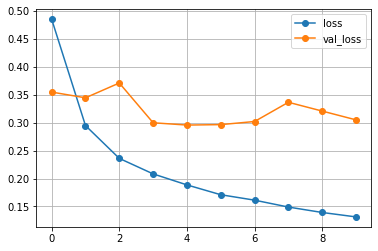

In [23]:
# 손실 곡선
hist[['loss', 'val_loss']].plot(marker='o')
plt.grid()
plt.show()

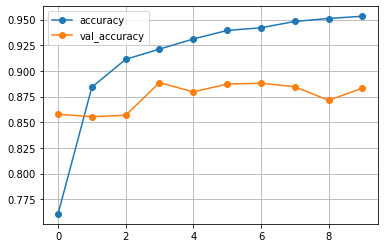

In [24]:
# 정확도 곡선
hist[['accuracy', 'val_accuracy']].plot(marker='o')
plt.grid()
plt.show()

In [25]:
# 검증 셋 평가
model.evaluate(x_val, y_val)

157/157 [==============================] - 2s 15ms/step - loss: 0.2957 - accuracy: 0.8796


[0.29570436477661133, 0.8795999884605408]

In [26]:
# 테스트 셋 평가
model.evaluate(x_test_seq, y_test)

782/782 [==============================] - 11s 14ms/step - loss: 0.3187 - accuracy: 0.8689


[0.3187044858932495, 0.8688799738883972]